In [38]:
import pandas as pd
import matplotlib.pyplot as plt

## Table 1

In [39]:
filepath = "https://raw.githubusercontent.com/ZeliaDec/Econ/main/"
table2_data = pd.read_stata(filepath+"T2_data.dta")

************************************************************************
				VARIABLES 							
*************************************************************************
					
- IN_DATA	A dummy indicating whether the unit is included in the analysis
 			(units are excluded if one or more variables are missing).
- FAC_ID	A unique facility identifier
- OWN_ID	A unique owner identifier
- UNIt_ID	A unique boiler identifier
- REGIME	Indicates if the facility is deregulated (1) regulated (2) or public(3)					
- U_CAP		Summer capacity (MW)
- U_SUM_HR	Summer heat rate (kWh/btu)
- U_AGE		Plant age (as of 2000)
- U_SUM_CF	Plant capcity factor
- PRE_RET_	Pre-retrofit NOx emissions rate
					
- D_SCR		Dummy indicating SCR retrofit
- D_SNCR	Dummy indicating SNCR retrofit
- D_LN		Dummy indicating LNB retrofit
- D_CM		Dummy indicating CM retrofit					
- D_NO		Dummy indicating no retrofit

- C_CM		CM retrofit dummy * capacity	
- C_NONE	No retrofit dummy * capacity	
- C_LN		LN retrofit dummy * capacity	
- C_SC		SC retrofit dummy * capacity						
- C_SN	  	SN retrofit dummy * capacity	

- REG		Regulated unit dummy
- PUB		Public dummy
- UNREG		Unregulated unit dummy

**************************************************************************************/

In [40]:
table2_data['REGIME'].unique()

array([2., 3., 1.], dtype=float32)

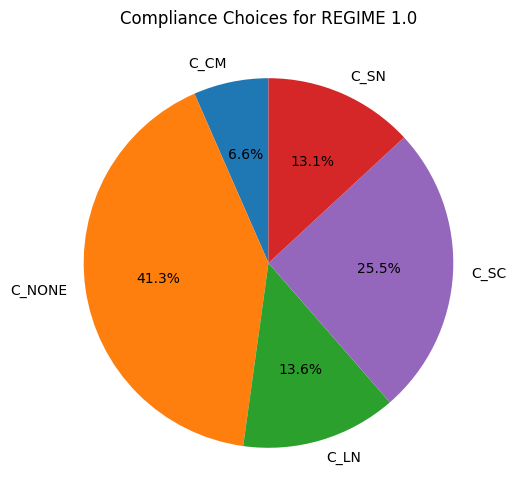

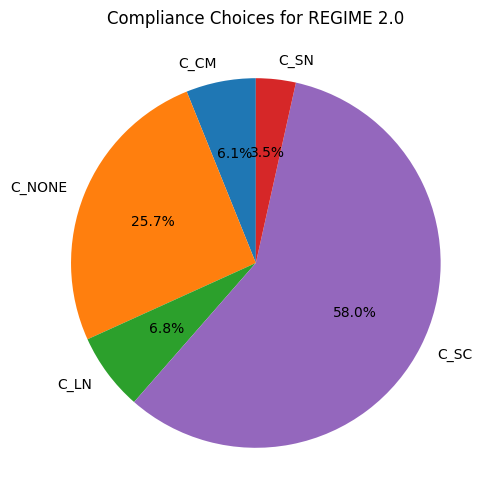

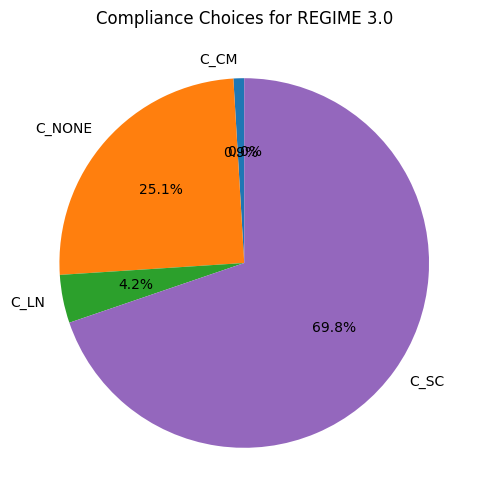

In [41]:
# Generate table for compliance choices by regime
compliance_choices = table2_data.groupby("REGIME")[["C_CM", "C_NONE", "C_LN", "C_SC", "C_SN"]].sum().reset_index()

color_palette = {
    "C_CM": "#1f77b4",    # Blue
    "C_NONE": "#ff7f0e",  # Orange
    "C_LN": "#2ca02c",    # Green
    "C_SC": "#9467bd",    # Red
    "C_SN": "#d62728"     # Purple
}

for regime in compliance_choices['REGIME'].unique():
    # Filter rows for the current regime
    regime_data = compliance_choices[compliance_choices['REGIME'] == regime]
    
    # Drop the REGIME column and transpose to get a single Series for pie chart
    regime_data = regime_data.drop(columns=['REGIME']).iloc[0]
    
    # Map colors to the columns
    colors = [color_palette[col] for col in regime_data.index]
    
    # Plot the pie chart
    plt.figure(figsize=(6, 6))
    regime_data.plot.pie(
        autopct='%1.1f%%', 
        labels=regime_data.index, 
        startangle=90,
        colors=colors
    )
    
    # Add title and remove y-label
    plt.title(f"Compliance Choices for REGIME {regime}")
    plt.ylabel("")  # Remove the y-axis label for cleaner look
    plt.show()

In [42]:
# Summary statistics for missing data
missing_data_summary = table2_data.groupby("IN_DATA").agg({
    "U_CAP": ["mean", "count"],
    "U_AGE": ["mean", "count"]
})
print("\nSummary Statistics for Missing Data:")
print(missing_data_summary)


Summary Statistics for Missing Data:
              U_CAP            U_AGE      
               mean count       mean count
IN_DATA                                   
0.0       51.653061    81  21.065790    76
1.0      271.716309   632  36.167721   632


In [43]:
# Filter to include only rows where IN_DATA == 1
filtered_data = table2_data[table2_data["IN_DATA"] == 1]

In [44]:
# Summarize capacity and unit age
capacity_age_summary = filtered_data.groupby("REGIME").agg({
    "U_CAP": ["mean", "std"],
    "U_AGE": ["mean", "std"]
})
print("\nCapacity and Unit Age Summary:")
print(capacity_age_summary)


Capacity and Unit Age Summary:
             U_CAP                  U_AGE           
              mean         std       mean        std
REGIME                                              
1.0     248.765808  211.752838  37.383259  11.448163
2.0     314.028656  278.950714  35.513699  11.404609
3.0     208.482300  226.789047  35.415928  10.972145


In [45]:
# Summarize summer heat rate and pre-retrofit emissions rates
heat_emissions_summary = filtered_data.groupby("REGIME").agg({
    "U_SUM_HR": ["mean", "std"],
    "PRE_RET_MNEMI": ["mean", "std"]
})
print("\nSummer Heat Rate and Pre-Retrofit Emissions Summary:")
print(heat_emissions_summary)


Summer Heat Rate and Pre-Retrofit Emissions Summary:
            U_SUM_HR              PRE_RET_MNEMI          
                mean          std          mean       std
REGIME                                                   
1.0     12119.952148  4746.764648      0.478002  0.207366
2.0     11866.420898  5955.843750      0.537068  0.216587
3.0     12183.877930  1897.702759      0.552077  0.225908


In [46]:
# Summarize summer capacity factors
capacity_factors_summary = filtered_data.groupby("REGIME").agg({
    "U_SUM_CF": ["mean", "std"]
})
print("\nSummer Capacity Factors Summary:")
print(round(capacity_factors_summary))


Summer Capacity Factors Summary:
       U_SUM_CF      
           mean   std
REGIME               
1.0        63.0  17.0
2.0        67.0  14.0
3.0        68.0  13.0


## Table 2 & 3

In [47]:
table3_4_data = pd.read_stata(filepath+"T_3_4.dta")

In [48]:
# Generate CS_CM column
table3_4_data['CS_CM'] = 0
table3_4_data.loc[(table3_4_data['C_CM'] == 1) | (table3_4_data['C_OFA'] == 1), 'CS_CM'] = 1

In [49]:
# Generate CS_LN column
table3_4_data['CS_LN'] = 0
table3_4_data.loc[(table3_4_data['C_LNC1'] == 1) | (table3_4_data['C_LNC2'] == 1) | (table3_4_data['C_LNC3'] == 1) | (table3_4_data['C_LNB'] == 1) | (table3_4_data['C_LNBO'] == 1), 'CS_LN'] = 1

In [50]:
# Generate CHOICE column
table3_4_data['CHOICE'] = (table3_4_data['C_CM_LNC1'] + table3_4_data['C_CM'] + table3_4_data['C_LNC1'] + table3_4_data['C_LNC2'] + table3_4_data['C_LNC3'] + 
                  table3_4_data['C_LNC3_SCR'] + table3_4_data['C_LNB'] + table3_4_data['C_LNBO'] + table3_4_data['C_LOSC'] + table3_4_data['C_NONE'] + 
                  table3_4_data['C_OFA'] + table3_4_data['C_LOSC'] + table3_4_data['C_OSNCR'] + table3_4_data['C_SCR'] + table3_4_data['C_SNCR'])

In [51]:
# Table 3
table_4 = table3_4_data.groupby('REGIME').agg({
    'CHOICE': ['mean', 'std'],
    'CS_CM': 'mean',
    'CS_LN': 'mean',
    'C_SNCR': 'mean',
    'C_SCR': 'mean',
})
print("Table 4:")
print(table_4)

Table 4:
          CHOICE               CS_CM     CS_LN    C_SNCR C_SCR
            mean       std      mean      mean      mean  mean
REGIME                                                        
1.0     6.829295  1.892290  0.964207  0.675661  0.900881   1.0
2.0     6.591206  2.046619  0.982586  0.606443  0.963431   1.0
3.0     6.406284  2.032983  0.972914  0.458288  0.919827   1.0


In [58]:
# Filter data for Table 2
filtered_data = table3_4_data[table3_4_data['TECH_FINAL'].isin(['CM', 'LNB', 'N', 'SC', 'SN'])]

# Table 4
table_3 = filtered_data.groupby(['REGIME', 'TECH_FINAL']).agg({
    'F': ['mean', 'std'],
    'V1': ['mean', 'std']
})

#table_3 = table_3.applymap(lambda x: round(x, 2))
print("Table 2:")
print(table_3)

Table 2:
                           F                   V1          
                        mean        std      mean       std
REGIME TECH_FINAL                                          
1.0    CM          12.632188   4.187821  0.009060  0.003772
       LNB         19.100000   5.890611  0.008312  0.002953
       N            0.000000   0.000000  0.012502  0.005771
       SC          71.206612  22.172060  0.005317  0.003513
       SN          17.362318  14.452998  0.009477  0.004241
2.0    CM          12.458436   5.019562  0.010512  0.003883
       LNB         17.198668   3.155411  0.008634  0.002324
       N            0.000000   0.000000  0.013391  0.005667
       SC          68.384209  19.917984  0.005067  0.001557
       SN          15.688087  14.592924  0.010180  0.003754
3.0    CM          11.854651   4.245320  0.010779  0.003834
       LNB         18.792454   4.199856  0.008546  0.002100
       N            0.000000   0.000000  0.015031  0.006700
       SC          81.009117  3